In [1]:
SEED = 42

import os
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

import random 
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

import tensorflow as tf
tf.random.set_seed(SEED)

In [2]:
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import math
import copy
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
from glob import glob
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
image = []
label = []
import os
for dirname, folders, filenames in os.walk('../input/caltech-101/caltech-101'):
    for folder in folders:
        print(folder)
        #get the images in each of these folder
        path = os.path.join(dirname,folder)
        for image_path in glob(os.path.join(path, "*.jpg")):
                im = cv2.imread(image_path, cv2.IMREAD_COLOR)
                im = cv2.resize(im, (60,75), interpolation = cv2.INTER_AREA)
                image.append(im)
                label.append(folder)
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

scorpion
hedgehog
crocodile_head
headphone
mandolin
ewer
stop_sign
ant
ferry
butterfly
airplanes
ibis
lobster
buddha
yin_yang
hawksbill
helicopter
pigeon
snoopy
Leopards
pagoda
Faces
cup
Faces_easy
inline_skate
wheelchair
wild_cat
cougar_body
sea_horse
emu
water_lilly
laptop
strawberry
bass
platypus
metronome
ketch
grand_piano
lamp
gramophone
kangaroo
starfish
dalmatian
bonsai
wrench
flamingo_head
umbrella
stegosaurus
revolver
gerenuk
beaver
barrel
anchor
saxophone
dollar_bill
nautilus
elephant
llama
dragonfly
cougar_face
chandelier
Motorbikes
octopus
pyramid
cannon
crayfish
panda
menorah
stapler
flamingo
mayfly
windsor_chair
scissors
crab
car_side
brain
tick
chair
rhino
dolphin
rooster
okapi
pizza
soccer_ball
garfield
ceiling_fan
schooner
joshua_tree
crocodile
brontosaurus
euphonium
minaret
sunflower
BACKGROUND_Google
cellphone
trilobite
lotus
accordion
watch
binocular
camera
electric_guitar


butterfly


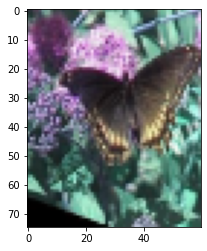

In [4]:
import matplotlib.pyplot as plt
plt.imshow(image[590])
print(label[590])

In [5]:
from sklearn.model_selection import train_test_split
trainx, testx, trainy, testy = train_test_split(image, label, 
                                            test_size=0.3)

In [6]:
def computeSIFT(data):
    x = []
    sift = cv2.SIFT_create()
    for i in range(len(data)):
        img = data[i]
        step_size = 25
        kp = [cv2.KeyPoint(x, y, step_size) for x in range(0, img.shape[0], step_size) for y in range(0, img.shape[1], step_size)]
        dense_feat = sift.compute(img, kp)
        x.append(dense_feat[1])
    return x

x_train = computeSIFT(trainx)
x_test = computeSIFT(testx)

all_train_desc = []
for i in range(len(x_train)):
    for j in range(x_train[i].shape[0]):
        all_train_desc.append(x_train[i][j,:])

all_train_desc = np.array(all_train_desc)

In [7]:
from sklearn.cluster import MiniBatchKMeans
clusters = MiniBatchKMeans(n_clusters=200, max_iter=10000, batch_size=1000)
clusters.fit(all_train_desc)

MiniBatchKMeans(batch_size=1000, max_iter=10000, n_clusters=200)

In [8]:
import math
def getImageFeaturesSPM(L, img, clusters, k):
    W = img.shape[1]
    H = img.shape[0]   
    h = []
    for l in range(L+1):
        w_step = math.floor(W/(2**l))
        h_step = math.floor(H/(2**l))
        x, y = 0, 0
        for _ in range(2**l):
            x = 0
            for _ in range(2**l):
                desc = extractSIFT(img[y:y+h_step, x:x+w_step])                
                predict = clusters.predict(desc)
                histo = np.bincount(predict, minlength=k).reshape(1,-1).ravel()
                weight = 2**(l-L)
                h.append(weight*histo)
                x = x + w_step
            y = y + h_step
            
    hist = np.array(h).ravel().astype('float64')
    dev = np.std(hist)
    hist -= np.mean(hist)
    hist /= dev
    return hist

def getImageFeaturesBOW(l, img, clusters, k):
    W = img.shape[1]
    H = img.shape[0]   
    h = []
    w_step = math.floor(W/(2**l))
    h_step = math.floor(H/(2**l))
    x, y = 0, 0
    for _ in range(2**l):
        x = 0
        for _ in range(2**l):
                desc = extractSIFT(img[y:y+h_step, x:x+w_step]) 
                predict = clusters.predict(desc)
                histo = np.bincount(predict, minlength=k).reshape(1,-1).ravel()
                h.append(histo)
                x = x + w_step
        y = y + h_step
            
    hist = np.array(h).ravel().astype('float64')
    dev = np.std(hist)
    hist -= np.mean(hist)
    hist /= dev
    return hist

def getHistogramSPM(L, data, clusters, k):    
    x = []
    for i in range(len(data)):        
        hist = getImageFeaturesSPM(L, data[i], clusters, k)        
        x.append(hist)
    return np.array(x)


def getHistogramBOW(L, data, clusters, k):    
    x = []
    for i in range(len(data)):        
        hist = getImageFeaturesBOW(L, data[i], clusters, k)        
        x.append(hist)
    return np.array(x)

In [9]:
L = 3
M = 200

train_hist_spm = []
test_hist_spm = []

def extractSIFT(img):
    sift = cv2.SIFT_create()
    step_size = 25
    kp = [cv2.KeyPoint(x, y, step_size) for x in range(0, img.shape[0], step_size) for y in range(0, img.shape[1], step_size)]
    dense_feat = sift.compute(img, kp)
    return dense_feat[1]

for l in range(L):
    print(l)
    train_hist = getHistogramSPM(l, trainx, clusters, 200)
    test_hist = getHistogramSPM(l, testx, clusters, 200)
    train_hist_spm.append(train_hist)
    test_hist_spm.append(test_hist)

0
1
2


In [10]:
train_hist_bow = []
test_hist_bow = []

for l in range(L):
    print(l)
    train_hist = getHistogramBOW(l, trainx, clusters, 200)
    test_hist = getHistogramBOW(l, testx, clusters, 200)
    train_hist_bow.append(train_hist)
    test_hist_bow.append(test_hist)

0
1
2


In [11]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

def svc_param_selection(X_train, y_train, X_test, y_test):
    for l in range(len(X_train)):
        Cs = [0.007]
        param_grid = {'C': Cs}
        grid_search = GridSearchCV(LinearSVC(), param_grid)
        grid_search.fit(X_train[l], y_train)
        best_est = grid_search.best_estimator_
        yhat = best_est.predict(X_test[l])
        acc = accuracy_score(y_test, yhat)
        print(acc)

svc_param_selection(train_hist_bow , trainy, test_hist_bow, testy)

0.35459183673469385
0.3753644314868805
0.358600583090379


In [12]:
svc_param_selection(train_hist_spm , trainy, test_hist_spm, testy)

0.35459183673469385
0.40561224489795916
0.42674927113702626


In [13]:
def get_accuracy(X_train, y_train, X_test, y_test):
    accuracy = []
    for l in range(len(X_train)):
        model = SVC()
        ovr = OneVsRestClassifier(model)
        ovr.fit(X_train[l], y_train)
        yhat = ovr.predict(X_test[l])
        acc = accuracy_score(y_test, yhat)
        accuracy.append(acc)
        print(acc)
    print("\n")
    return accuracy

acc_bow = get_accuracy(train_hist_bow , trainy, test_hist_bow, testy)
acc_spm = get_accuracy(train_hist_spm , trainy, test_hist_spm, testy)

0.3432944606413994
0.41180758017492713
0.4260204081632653


0.3432944606413994
0.44533527696793
0.4774052478134111


